# AIML331 Assignment 1
## crowelenn | 300607096

In [44]:
import numpy as np

## Question 1: Camera Problem

**1.1** Your pinhole camera is at [X, Y, Z] = [0, 0, −10]] and sits on a horizontal table. It is pointing 30 degrees to the right relative to the origin of the world coordinates. Compute the [R, t] matrix converting world coordinates to camera coordinates.

In [45]:
yaw = np.radians(30)
pitch = np.radians(0)
roll = np.radians(0)

a = yaw
b = pitch
y = roll

In [46]:
from numpy import cos, sin

In [47]:
R = np.array(
    [
        [cos(b)*cos(y), sin(a)*sin(b)*cos(y) - cos(a)*sin(y), cos(a)*sin(b)*cos(y) + sin(a)*sin(y)],
        [cos(b)*sin(y), sin(a)*sin(b)*sin(y) + cos(a)*cos(y), cos(a)*sin(b)*sin(y) - sin(a)*cos(y)],
        [-sin(b), sin(a)*cos(b), cos(a)*cos(b)]
    ])

In [48]:
t = np.array([[0, 0, -10]]).T

In [49]:
Rt = np.concatenate((R, t), axis=1)
Rt = np.concatenate((Rt, [[0, 0, 0, 1]]), axis=0)

In [50]:
Rt

array([[  1.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.8660254,  -0.5      ,   0.       ],
       [ -0.       ,   0.5      ,   0.8660254, -10.       ],
       [  0.       ,   0.       ,   0.       ,   1.       ]])

**1.2** Your camera has f = 0.1 (focal length, as used in pinhole camera). Using homogeneous coordinates compute the equation of a line on the projective plane that goes through the points that correspond to [0, 1, 0] and [0, 0, 1] in the world coordinates

In [51]:
f = 0.1

In [52]:
K = np.array([[f, 0, 0, 0],
              [0, f, 0, 0],
              [0, 0, 1, 0]])

In [53]:
world_1 = np.array([[0, 1, 0, 1]]).T
world_2 = np.array([[0, 0, 1, 1]]).T

In [54]:
proj_1 = K @ Rt @ world_1

In [55]:
proj_2 = K @ Rt @ world_2

In [56]:
np.cross(proj_1.T, proj_2.T)

array([[-1.2660254,  0.       , -0.       ]])

This is a vertical line as the y-component is 0.

## Question 2: Checkerboard problem

**2.1** Find an image on-line that displays a checkerboard (provide source website).
Convert to gray-scale if it is colour

Image source: https://static.vecteezy.com/system/resources/thumbnails/000/639/981/small_2x/Black_and_white_checkered_pattern.jpg

I am using the pillow (PIL) package exclusively to load the image and convert it to a numpy array.


In [57]:
from PIL import Image

In [58]:
checkerboard = np.array(Image.open("check.jpg").convert("L"))

In [59]:
checkerboard.shape

(400, 400)

In [64]:
checkerboard

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

This image is already in greyscale so doesn't need to be converted.

**2.2** Write a program to compute the histogram and cumulative probability function
of the image and display result.

In [65]:
import matplotlib.pyplot as plt

In [60]:
checkerboard_hist = np.histogram(checkerboard, bins=256, range=(0, 256))[0]

In [61]:
checkerboard.reshape(-1).shape

(160000,)

In [62]:
def find_historgam(np_image):
    hist = np.zeros(256)

    for i in np_image.reshape(-1):
        hist[i] += 1

    return hist

In [75]:
def find_cdf(np_image):
    hist = find_historgam(np_image)
    im_total = np_image.reshape(-1).shape[0]
    cdf = np.zeros(256)

    for i in range(256):
        cdf[i] = hist[0:i+1].sum() / im_total

    return cdf

Text(0.5, 1.0, 'Histogram of the checkerboard image')

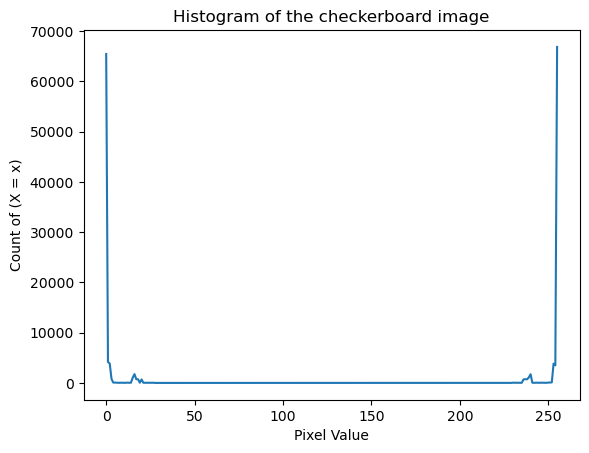

In [84]:
plt.plot(find_historgam(checkerboard))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the checkerboard image")

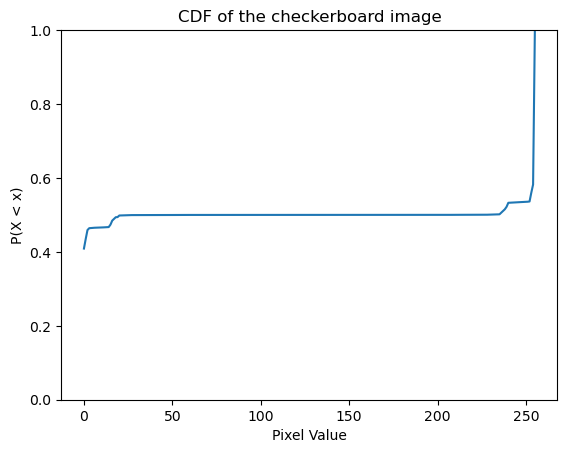

In [83]:
plt.plot(find_cdf(checkerboard))
plt.xlabel("Pixel Value")
plt.ylabel("P(X < x)")
plt.ylim(0, 1)
plt.title("CDF of the checkerboard image")
plt.show()

**2.3** Write a program to low-pass filter (smooth) the image in the spatial domain.
You can select the filter.

I am going to use a box filter.

In [148]:
kernel = np.ones((10, 10))

In [126]:
def do_convolution(image, kernel):
    N, M = kernel.shape
    output_image = np.zeros(image.shape)
    kernel_sum = np.sum(kernel)

    pad_h = N // 2
    pad_w = M // 2

    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output_image[i, j] = np.sum(kernel * padded_image[i:i+N, j:j+M]) / kernel_sum

    output_image = np.clip(output_image, 0, 255)

    return output_image.astype(np.uint8)

    #return output_image

In [127]:
output = Image.fromarray(do_convolution(checkerboard, kernel))

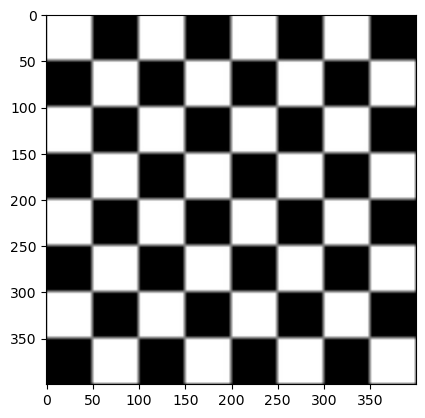

In [128]:
plt.imshow(output, cmap='gray')

**2.4** Explain if the low-pass filter you selected is separable.

A separable kernel can be reduced to a product of two vectors (1D filters). My filter is a \(10 \times 10\) matrix of 1's as follows:

\[
\begin{bmatrix}
    1       & 1 & 1 & \dots & 1 \\
    1       & 1 & 1 & \dots & 1 \\
    \vdots & \vdots & \ddots \\
    1       & 1 & 1 & \dots & 1
\end{bmatrix}
\]

This can be expressed as:

\[
\begin{bmatrix} 1 & 1 & 1 & \cdots & 1 \end{bmatrix}
\cdot
\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
\]





In [149]:
Im_fft = np.fft.fft2(checkerboard)

#Kernel_fft = np.fft.fft2(np.pad(kernel, ((0, 395), (0, 395)), mode='constant', constant_values=0))

In [150]:
kernel = kernel/100

In [151]:
padded_kernel = np.zeros((400, 400))
padded_kernel[:10, :10] = kernel
padded_kernel = np.fft.ifftshift(padded_kernel)

Im_fft = np.fft.fft2(checkerboard)
Kernel_fft = np.fft.fft2(padded_kernel)

In [152]:
frequency_convolution = np.multiply(Im_fft, Kernel_fft)

In [154]:
img_test = np.fft.ifft2(frequency_convolution).real

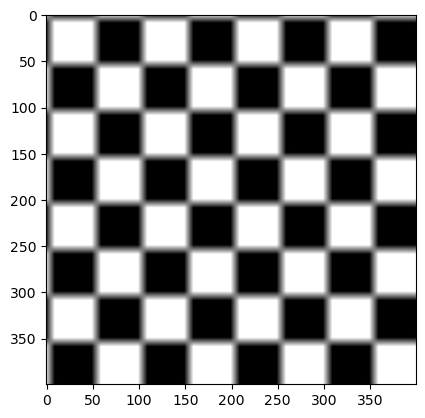

In [155]:
plt.imshow(img_test, cmap='gray')

**2.6** Compute the histogram of the low-pass filtered checkerboard image.

Text(0.5, 1.0, 'Histogram of the checkerboard image')

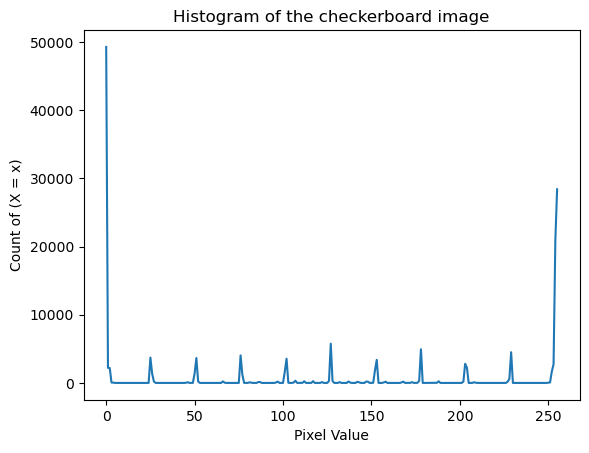

In [163]:
plt.plot(find_historgam(img_test.astype(np.uint8)))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the checkerboard image")

**2.7** Using cumulative distribution functions, convert your low-pass filtered checkerboard image to have a uniform probability of intensity levels.

In [170]:
def cdf_uniform(x):
    return x/255


In [171]:
def cdf_inverse(x):
    return 255*x

In [ ]:
desired_intensity = cdf_uniform #(cumulative probability from prev histogram)#

In [203]:
img_size = 400 * 400

In [243]:
j = 2
desired_intensity = cdf_inverse(find_cdf(checkerboard.astype(np.uint8)))

In [244]:
desired_intensity

array([104.288625 , 110.9281875, 117.0736875, 118.3486875, 118.4570625,
       118.5718125, 118.6546875, 118.6929375, 118.7630625, 118.8331875,
       118.8650625, 118.9033125, 118.9989375, 119.04675  , 119.116875 ,
       120.7903125, 123.579375 , 124.7619375, 125.925375 , 125.9923125,
       127.1015625, 127.1525625, 127.1971875, 127.2226875, 127.2481875,
       127.2928125, 127.3565625, 127.3820625, 127.3820625, 127.3820625,
       127.3820625, 127.38525  , 127.38525  , 127.38525  , 127.38525  ,
       127.38525  , 127.38525  , 127.38525  , 127.398    , 127.41075  ,
       127.41075  , 127.4235   , 127.4235   , 127.4235   , 127.4235   ,
       127.4235   , 127.4235   , 127.449    , 127.449    , 127.449    ,
       127.449    , 127.46175  , 127.46175  , 127.4745   , 127.4745   ,
       127.48725  , 127.48725  , 127.48725  , 127.48725  , 127.48725  ,
       127.48725  , 127.5      , 127.5      , 127.5      , 127.5      ,
       127.5      , 127.5      , 127.5      , 127.5      , 127.5

In [259]:
def map_to_cdf(image, cdf_inverse):
    image_copy = image.copy()
    intensities_map = cdf_inverse(find_cdf(image.astype(np.uint8)))


    for i in range(0, image.shape[0] - 1):
        for j in range(0, image.shape[1] - 1):
            image_copy[i, j] = intensities_map[image[i, j]]


    return image_copy

In [262]:
image_flattened = map_to_cdf(checkerboard.astype(np.uint8), cdf_inverse)

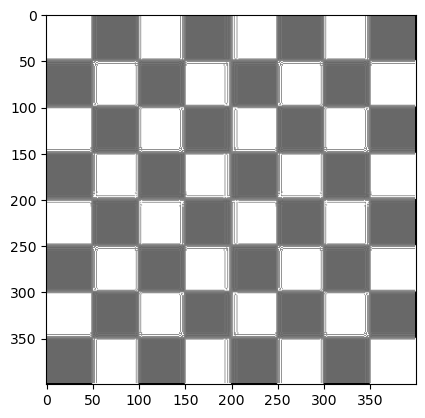

In [264]:
plt.imshow(image_flattened, cmap='gray')

Text(0.5, 1.0, 'Histogram of the flattened checkerboard image')

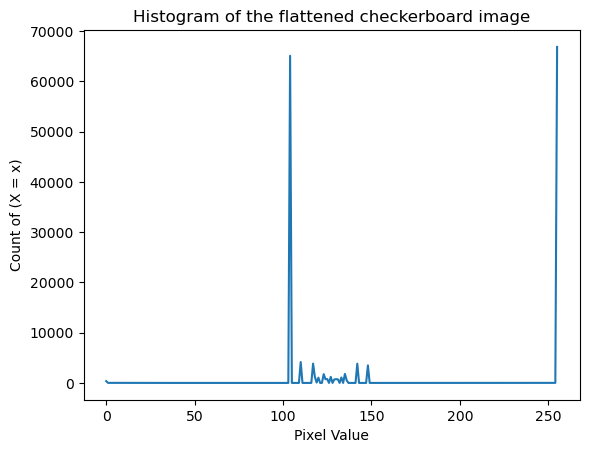

In [266]:
plt.plot(find_historgam(image_flattened.astype(np.uint8)))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the flattened checkerboard image")